# Support Vector Machine Test for IFFT Slope Model

## Building training data

Import libraries.

In [95]:
import yfinance as yf
import seaborn as sns
import ta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import special
import math
from ts2vg import HorizontalVG
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

Fetch historical stock data for a given ticker using yfinance.

In [96]:
ticker = "ADA-USD"  # You can replace this with any stock symbol, e.g., 'GOOGL', 'MSFT', etc.
start_date = "2022-06-01"
end_date = "2024-08-01"

# Download the data
df = yf.download(ticker, start=start_date, end=end_date)

df.drop(['Adj Close'],axis = 1,inplace = True)
df.reset_index(inplace=True, drop=True)

[*********************100%***********************]  1 of 1 completed


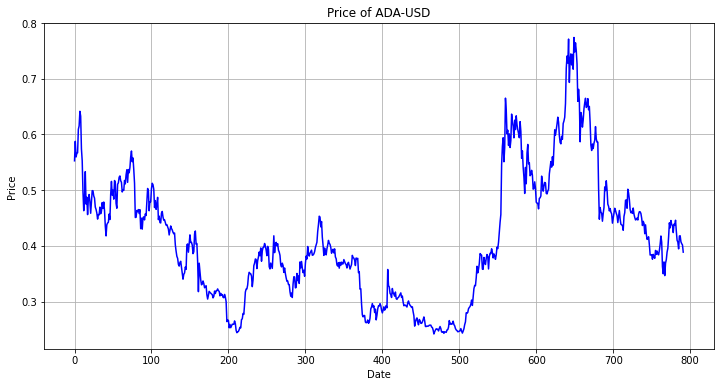

In [97]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Price', color='blue')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Price of {ticker}')
plt.grid()
plt.show()

### Adjustable technical parameters

volatility_window = Time period of variance calculation.

window_size = Length of rolling window. Length is defined as number of indicies.

slope_length = IFFT slope length is calculated over n number of ticks.

target_price = The target price as a %.

stop_loss = The stop loss as a %.

In [98]:
# Volatility window size
volatility_window = 5

# IFFT Window size
n = len(df)
window_size = min(20, n)

# IFFT Rolling Window Slope Long length
rw_slope_length = 7

# IFFT Slope Long length
slope_length = 20

# Target price
target_price = 0.04

# Stop loss
stop_loss = 0.02

### Calculate Volatility

Volatility is a measure of that variance bounded by a specific time period.

In [99]:
# Defining column
df['Volatility'] = 0

# Calculating variance over n ticks
for i in range(len(df)):
    if i > volatility_window:
        df['Volatility'].iloc[i] = np.var(df['Close'].iloc[i-volatility_window:i])
        
df['Volatility'] = np.log(df['Volatility'])

Plot Results.

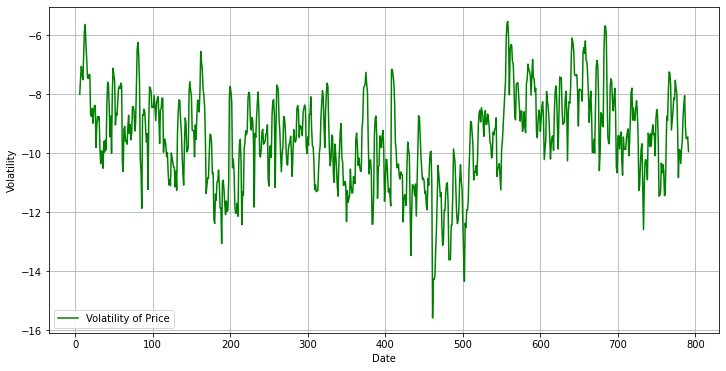

In [100]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Volatility'], label='Volatility of Price', color='green')

plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.legend()
plt.show()

### Relative Strength Index

In [101]:
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

### CCI

In [102]:
period = 20
df['CCI'] = ta.trend.CCIIndicator(
    high=df['High'], 
    low=df['Low'], 
    close=df['Close'], 
    window=period).cci()

### SuperTrend

In [103]:
def SuperTrend(df,f,n): #df is the dataframe, n is the period, f is the factor.
    
    # Calculating Average True Ragnge
    df = df.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs( df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR']=np.nan
    df.loc[n-1,'ATR']=df['TR'][:n-1].mean() #.ix is deprecated from pandas verion- 0.19
    for i in range(n,len(df)):
        df['ATR'][i]=(df['ATR'][i-1]*(n-1)+ df['TR'][i])/n

    # Calculation of upper and lower basic
    df['Upper Basic']=(df['High']+df['Low'])/2+(f*df['ATR'])
    df['Lower Basic']=(df['High']+df['Low'])/2-(f*df['ATR'])
    df['Upper Band']=df['Upper Basic']
    df['Lower Band']=df['Lower Basic']
    
    # Calculation upper bands
    for i in range(n,len(df)):
        if df['Close'][i-1]<=df['Upper Band'][i-1]:
            df['Upper Band'][i]=min(df['Upper Basic'][i],df['Upper Band'][i-1])
        else:
            df['Upper Band'][i]=df['Upper Basic'][i]
    
    # Calculation upper bands
    for i in range(n,len(df)):
        if df['Close'][i-1]>=df['Lower Band'][i-1]:
            df['Lower Band'][i]=max(df['Lower Basic'][i],df['Lower Band'][i-1])
        else:
            df['Lower Band'][i]=df['Lower Basic'][i]
    df['SuperTrend']=np.nan
    
    # Sets past Supertend equal to upper/lower band when it crosses the close price
    for i in df['SuperTrend']:
        if df['Close'][n-1]<=df['Upper Band'][n-1]:
            df['SuperTrend'][n-1]=df['Upper Band'][n-1]
        elif df['Close'][n-1]>df['Upper Band'][i]:
            df['SuperTrend'][n-1]=df['Lower Band'][n-1]
    
    # Sets Supertend equal to upper/lower band when it crosses the close price
    for i in range(n,len(df)):
        if df['SuperTrend'][i-1]==df['Upper Band'][i-1] and df['Close'][i]<=df['Upper Band'][i]:
            df['SuperTrend'][i]=df['Upper Band'][i]
        elif  df['SuperTrend'][i-1]==df['Upper Band'][i-1] and df['Close'][i]>=df['Upper Band'][i]:
            df['SuperTrend'][i]=df['Lower Band'][i]
        elif df['SuperTrend'][i-1]==df['Lower Band'][i-1] and df['Close'][i]>=df['Lower Band'][i]:
            df['SuperTrend'][i]=df['Lower Band'][i]
        elif df['SuperTrend'][i-1]==df['Lower Band'][i-1] and df['Close'][i]<=df['Lower Band'][i]:
            df['SuperTrend'][i]=df['Upper Band'][i]
    
    df.drop(['H-L', 'H-PC', 'L-PC', 'TR', 'Upper Basic', 'Lower Basic', 'Upper Band', 'Lower Band'] ,axis = 1,inplace = True)
    return df

df = SuperTrend(df, 2, 7)

### Time Irreversibility

In [104]:
def ordinal_patterns(arr: np.array, d: int) -> np.array:
    assert(d >= 2)
    fac = math.factorial(d);
    d1 = d - 1
    mults = []
    for i in range(1, d):
        mult = fac / math.factorial(i + 1)
        mults.append(mult)

    # Create array to put ordinal pattern in
    ordinals = np.empty(len(arr))
    ordinals[:] = np.nan

    for i in range(d1, len(arr)):
        dat = arr[i - d1:  i+1]
        pattern_ordinal = 0
        for l in range(1, d):
            count = 0
            for r in range(l):
                if dat[d1 - l] >= dat[d1 - r]:
                    count += 1

            pattern_ordinal += count * mults[l - 1]
        ordinals[i] = int(pattern_ordinal)

    return ordinals

def perm_ts_reversibility(arr: np.array):
    # Zanin, M.; Rodríguez-González, A.; Menasalvas Ruiz, E.; Papo, D. Assessing time series reversibility through permutation
    
    # Should be fairly large array, very least ~60
    assert(len(arr) >= 10)
    rev_arr = np.flip(arr)
   
    # [2:] drops 2 nan values off start of val
    pats = ordinal_patterns(arr, 3)[2:].astype(int)
    r_pats = ordinal_patterns(rev_arr, 3)[2:].astype(int)
   
    # pdf of patterns, forward and reverse time
    n = len(arr) - 2
    p_f = np.bincount(pats, minlength=6) / n 
    p_r = np.bincount(r_pats, minlength=6) / n

    if min(np.min(p_f), np.min(p_r)) > 0.0:
        rev = scipy.special.rel_entr(p_f, p_r).sum()
    else:
        rev = np.nan
        
    return rev

def async_index(arr1: np.array, arr2: np.array):
    # Computes asynchronous index (AI) from arr1 -> arr2
    # Note AI(arr1, arr2) != AI(arr2, arr1)
    # (Not always !=, but it can be !=)
    assert(len(arr1) == len(arr2))

    n = len(arr1)
    perm = np.argsort(arr1)

    norm_const = (n * (n - 1)) / 2.0

    # Compute async index
    inversion_n = 0
    for i in range(n):
        for j in range(i+1, n):
            diff = arr2[perm[i]] - arr2[perm[j]] 
            if diff > 0:
                inversion_n += 1 # Possibly add weighting to this 1

    return inversion_n / norm_const

def relative_async_index(arr: np.array):
    n = arr.shape[0]

    hvg_f = HorizontalVG()
    hvg_r = HorizontalVG()
    hvg_f.build(arr)
    hvg_r.build(np.flip(arr))

    hvg_f = hvg_f.adjacency_matrix()
    hvg_r = hvg_r.adjacency_matrix()
    
    # Find out-going links from forward and reverse time series
    out_f = np.zeros(n, dtype=int)
    out_r = np.zeros(n, dtype=int)
    for i in range(n):
        out_f[i] = np.sum(hvg_f[i, i:])
        out_r[i] = np.sum(hvg_r[i, i:])
    
    f_r = async_index(out_f, out_r)
    r_f = async_index(out_r, out_f)

    rai = -np.log(min(f_r, r_f) / max(f_r, r_f))
    
    return rai

def logistic_map(n: int, init: float = 0.49, mu: float = -1.87):
    # For more info go to 
    # https://en.wikipedia.org/wiki/Logistic_map 
    arr = np.zeros(n)
    arr[0] = init
    for i in range(1, n):
        arr[i] = mu * arr[i-1] * (1 - arr[i-1])
    return arr

def henon_map(n: int, init: float = 0.618, a: float = 1.4, b: float = 0.3):
    # https://en.wikipedia.org/wiki/Logistic_map
    y = 0.1
    x = init
    y_ = x_ = 0 # Next x,y

    arr = np.zeros(n)
    for i in range(n):
        x_ = 1 - a * x ** 2 + y
        y_ = b * y
        x, y = x_, y_
        arr[i] = x

    return arr

def rw_ptsr(arr: np.array, lookback: int):
    # Rolling window permutation time series reversibility
    rev = np.zeros(len(arr))
    rev[:] = np.nan
    
    lookback_ = lookback + 2
    for i in range(lookback_, len(arr)):
        dat = arr[i - lookback_ + 1: i+1]
        rev_w = perm_ts_reversibility(dat) 

        if np.isnan(rev_w):
            rev[i] = rev[i - 1]
        else:
            rev[i] = rev_w

    return rev

def rw_rai(arr: np.array, lookback: int):
    # Rolling window relative asynchronous index
    rev = np.zeros(len(arr))
    rev[:] = np.nan
    
    rev_w = 0
    
    for i in range(lookback, len(arr)):
        
        dat = arr[i - lookback + 1: i+1]
        rev_w = relative_async_index(dat) 
        rev[i] = rev_w
        
    return rev
    
# You could use changes in price instead.  
df['Log Close'] = np.log(df['Close']).diff()

lb = 30
df['rai'] =  rw_rai(df['Close'].to_numpy(), lb)
df['ptsr'] =  rw_ptsr(df['Close'].to_numpy(), lb)
df['rai_s'] = df['rai'].ewm(7).mean()

### Inverse Fast Fourier Transform short and long term IFFT slope

IFFT smooths data.

Short term slope informs the model of the immediate direction and short term trend of the price. Information that would be otherwise unavailable if only looking at the current price.

The long term slope is calculated to inform the model of the long/medium term trend of the stock

This also allows the model to recieve time series data from past stock ticks, rather than soley relying on one dimensional data from the current point in time. For example, if the slope length is set to 30, the model is able to see data from the previous 30 ticks.

An alternative to this method might be creating new columns with data for current price - n, which would be far less efficient.

In [105]:
 # Calculate IFFT
    
# IFFT Indicator with Padding
def ifft_indicator(prices, threshold, padding):
    n = len(prices)
    
    # Pad the prices with reflection at both ends
    padding_size = int(n * padding)  # 0.5 = 50% of the size for padding
    padded_prices = np.pad(prices, (padding_size, padding_size), mode='reflect')

    fft_transformed = np.fft.fft(padded_prices)
    fft_filtered = np.zeros_like(fft_transformed)

    retain_length = int(threshold * len(padded_prices))
    fft_filtered[:retain_length] = fft_transformed[:retain_length]
    fft_filtered[-retain_length:] = fft_transformed[-retain_length:]

    ifft_transformed = np.fft.ifft(fft_filtered).real

    # Remove padding
    ifft_transformed = ifft_transformed[padding_size:-padding_size]

    return ifft_transformed  

# Rolling window
df['IFFT RW'] = np.nan
for i in range(len(df) - window_size):
    window_data = df.loc[i: i+window_size]
    window_closing_prices = window_data['Close'].values
    window_ifft_result = ifft_indicator(window_closing_prices, threshold=0.05, padding=0.5)
    df['IFFT RW'].iloc[i+window_size] = window_ifft_result[-1]

# Short term slope of Standard IFFT
df['IFFT Slope Short'] = np.nan
for i in range(len(df)):
    if i > slope_length:
        ifft_result = ifft_indicator(df['Close'], threshold=0.05, padding=0.5)
        slope = (ifft_result[i] - ifft_result[i-1])
        df['IFFT Slope Short'].iloc[i] = slope
        
# Long term slope of Standard IFFT
df['IFFT Slope Long'] = np.nan
for i in range(len(df)):
    if i > slope_length:
        ifft_result = ifft_indicator(df['Close'], threshold=0.05, padding=0.5)
        slope = (ifft_result[i] - ifft_result[i-slope_length]) / (slope_length - 1)
        df['IFFT Slope Long'].iloc[i] = slope
        
# Calculate the slope of the IFFT
df['IFFT RW Slope Short'] = 0
df['IFFT RW Slope Short'] = df['IFFT RW'].diff()

# Calculate long IFFT RW Slope
df['IFFT RW Slope Long'] = 0
for i in range(len(df)):
    if i > rw_slope_length:
        df['IFFT RW Slope Long'].iloc[i] = (df['IFFT RW'].iloc[i] - df['IFFT RW'].iloc[i-rw_slope_length]) / (rw_slope_length - 1)

Calculate rolling window for IFFT.

In [106]:
df

,Open,High,Low,Close,Volume,Volatility,RSI,CCI,ATR,SuperTrend,Log Close,rai,ptsr,rai_s,IFFT RW,IFFT Slope Short,IFFT Slope Long,IFFT RW Slope Short,IFFT RW Slope Long
0,0.625417,0.629977,0.540809,0.552750,1404107650,-inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,0.552636,0.595811,0.550444,0.587795,1257661647,-inf,NaN,NaN,NaN,NaN,0.061472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,0.587836,0.603290,0.541486,0.559658,910186327,-inf,NaN,NaN,NaN,NaN,-0.049052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,0.559957,0.570570,0.548088,0.566069,559861766,-inf,NaN,NaN,NaN,NaN,0.011390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,0.566091,0.579553,0.556398,0.567090,478128224,-inf,NaN,NaN,NaN,NaN,0.001802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,0.417746,0.428685,0.414101,0.418198,430162296,-9.076221,51.382648,11.988280,0.021886,0.440928,0.001079,0.154151,0.390256,0.091428,0.415958,-0.005903,0.001253,-0.003155,-0.004597
788,0.418195,0.420287,0.405600,0.407387,261455853,-9.508850,47.972091,-32.237315,0.020858,0.440928,-0.026191,0.016394,0.308216,0.082049,0.412864,-0.005094,0.000834,-0.003094,-0.005472
789,0.407387,0.426437,0.403783,0.404014,328634235,-9.501586,46.925558,-43.645147,0.021114,0.440928,-0.008314,0.056089,0.308216,0.078804,0.409292,-0.003916,0.000418,-0.003572,-0.006019
790,0.404008,0.406977,0.396082,0.401680,277821308,-9.453392,46.174904,-97.217883,0.019654,0.440838,-0.005794,0.131336,0.228107,0.085371,0.406087,-0.002455,0.000023,-0.003205,-0.005760


Drop zero a d null values

In [107]:
# Fix dataframe
df.reset_index(inplace=True, drop=True)
df = df[df['IFFT RW Slope Long'] != 0]
df = df[df['Volatility'] != 0]
df = df.dropna()
len(df)

760

Plot results.

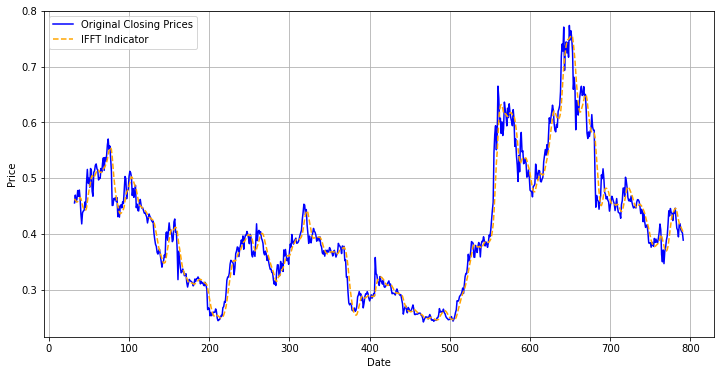

In [108]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Original Closing Prices', color='blue')
plt.plot(df.index, df['IFFT RW'], label='IFFT Indicator', color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.legend()
plt.show()

Plot slope data.

Include hypothetical threshold where slope above that threshold could trigger a buy or sell signal.

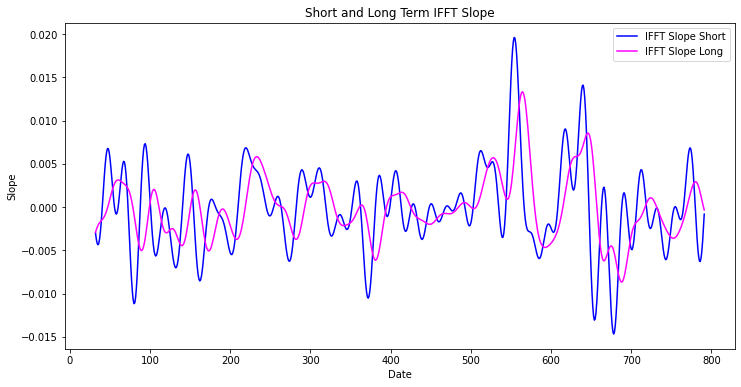

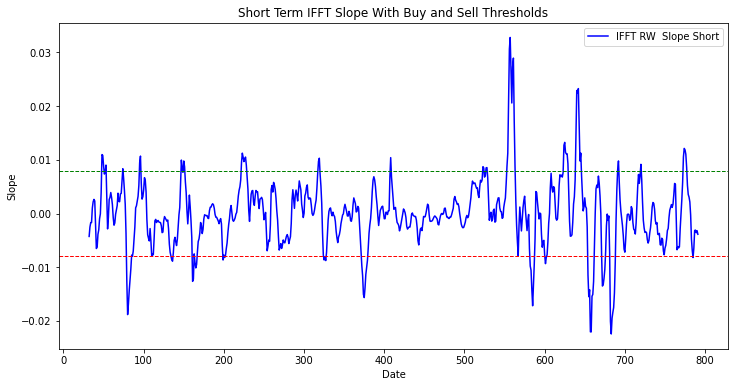

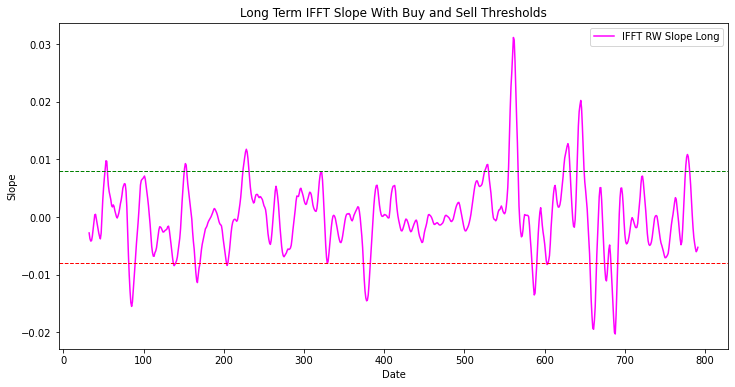

In [109]:
# Plotting short and long term IFFT slope
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['IFFT Slope Short'], label='IFFT Slope Short', color='blue')
plt.plot(df.index, df['IFFT Slope Long'], label='IFFT Slope Long', color='magenta')

# Labeling graph
plt.title('Short and Long Term IFFT Slope')
plt.xlabel('Date')
plt.ylabel('Slope')
plt.legend()
plt.show()

# Plotting short term IFFT slope
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['IFFT RW Slope Short'], label='IFFT RW  Slope Short', color='blue')

# Add theoretical short slope threshold
plt.axhline(y=0.008, color='green', linestyle='--', linewidth=1)

# Add theoretical short slope threshold
plt.axhline(y=-0.008, color='red', linestyle='--', linewidth=1)

# Labeling graph
plt.title('Short Term IFFT Slope With Buy and Sell Thresholds')
plt.xlabel('Date')
plt.ylabel('Slope')
plt.legend()
plt.show()

# Plotting long term IFFT slope
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['IFFT RW Slope Long'], label='IFFT RW Slope Long', color='magenta')

# Add theoretical long slope threshold
plt.axhline(y=0.008, color='green', linestyle='--', linewidth=1)

# Add theoretical long slope threshold
plt.axhline(y=-0.008, color='red', linestyle='--', linewidth=1)

# Labeling graph
plt.title('Long Term IFFT Slope With Buy and Sell Thresholds')
plt.xlabel('Date')
plt.ylabel('Slope')
plt.legend()
plt.show()

## Labeling data



In [110]:
# Add direction column to label data
df['Direction'] = 0 # 1 for up, -1 for down

# Loop over data to determine the movement
for i in range(len(df)):
    current_price = df['Close'].iloc[i]
    found_movement = False  # Flag to indicate if a movement was found

    # Check for price movement within the subsequent days
    for j in range(i + 1, len(df)):
        future_price = df['Close'].iloc[j]
        change = (future_price - current_price) / current_price

        if change >= target_price:
            df['Direction'].iloc[i] = 1  # Upward Win
            found_movement = True
            break  # Stop after the first movement is found

        elif change <= stop_loss * -1:
            break  # Stop after the first movement is found

    # Check for price movement within the subsequent days
    for j in range(i + 1, len(df)):
        future_price = df['Close'].iloc[j]
        change = (future_price - current_price) / current_price

        if change <= target_price * -1:
            df['Direction'].iloc[i] = -1  # Upward Win
            found_movement = True
            break  # Stop after the first movement is found

        elif change >= stop_loss:
            break  # Stop after the first movement is found

    # If no movement found within the loop, record as loss
    if not found_movement:
        df['Direction'].iloc[i] = 0  # No movement

Plot labeled data.

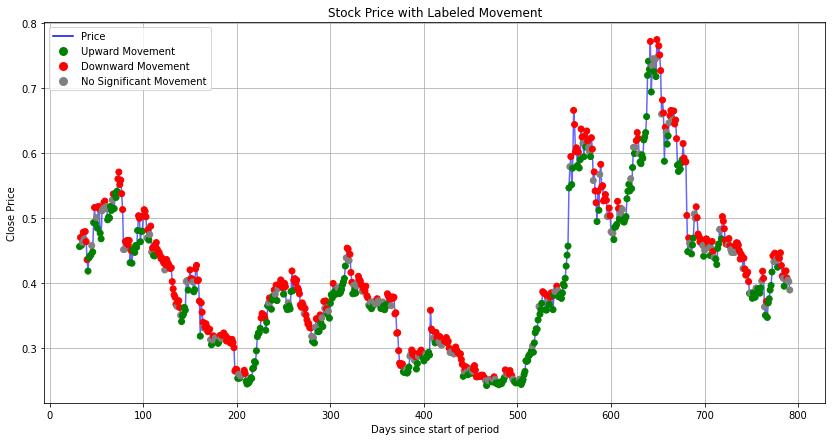

In [111]:
# Plot the stock prices
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', color='blue', alpha=0.6)

# Create a list with colors based on the values in the 'Direction' column
colors = ['red' if x == -1 else 'grey' if x == 0 else 'green' for x in df['Direction']]

# Plot prices with color-coded results
plt.scatter(df.index, df['Close'], c=colors, label='Ticks', zorder=5)

# Customize the plot
plt.title('Stock Price with Labeled Movement')
plt.xlabel('Days since start of period')
plt.ylabel('Close Price')

# Add a legend to explain the color coding
legend_labels = {
    'blue': 'Price',
    'green': 'Upward Movement',
    'red': 'Downward Movement',
    'grey': 'No Significant Movement'
}

# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], linestyle='-', color='blue', label=legend_labels['blue']),
    plt.Line2D([0], [0], marker='o', color='w', label=legend_labels['green'],
               markersize=10, markerfacecolor='green'),
    plt.Line2D([0], [0], marker='o', color='w', label=legend_labels['red'],
               markersize=10, markerfacecolor='red'),
    plt.Line2D([0], [0], marker='o', color='w', label=legend_labels['grey'],
               markersize=10, markerfacecolor='grey')]

# Add legend to plot
plt.legend(handles=legend_handles, loc='upper left')

plt.grid(True)
plt.show()

## Further Cleaning and Testing

In [112]:
# Drop columns unnecessary for training
close = df['Close']

# Removing no movement value because it is not relevant to prediction, increases autocorrelation
df = df[df['Direction'] != 0]
df.reset_index(inplace=True, drop=True)
df.head()

,Open,High,Low,Close,Volume,Volatility,RSI,CCI,ATR,SuperTrend,Log Close,rai,ptsr,rai_s,IFFT RW,IFFT Slope Short,IFFT Slope Long,IFFT RW Slope Short,IFFT RW Slope Long,Direction
0,0.456321,0.458882,0.444546,0.455587,439469536,-9.790443,39.726132,-109.075850,0.028231,0.508176,-0.001676,0.223144,0.274856,0.175706,0.462995,-0.003003,-0.002924,-0.004270,-0.002755,1
1,0.455612,0.473209,0.445301,0.469644,808524892,-10.365080,44.055658,-59.981488,0.028185,0.508176,0.030388,0.026202,0.106474,0.130546,0.460473,-0.003699,-0.002614,-0.002522,-0.003748,-1
2,0.469569,0.470673,0.445440,0.457632,766706338,-9.933389,41.324032,-73.612724,0.027763,0.508176,-0.025910,0.032790,0.156822,0.105460,0.458778,-0.004169,-0.002352,-0.001695,-0.004166,1
3,0.462210,0.481945,0.461557,0.477812,619107061,-10.514031,47.557518,9.119307,0.025168,0.508176,0.033265,0.046884,0.258910,0.090794,0.458145,-0.004214,-0.001959,0.001038,-0.003317,-1
4,0.467290,0.484265,0.466491,0.478760,666827059,-9.965566,48.307085,17.843175,0.024581,0.508176,0.024204,0.011173,0.279685,0.075343,0.462953,-0.002954,-0.001698,0.002628,-0.000719,-1


### Testing for Autocorrelation

Importing Statistics Libraries

In [113]:
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Using the Durbin-Watson Test to check for autocorrelation

In [114]:
# Split the data
df2 = df.copy()

X = df2.drop(columns=['Direction'])

y = df2['Direction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a logistic regression model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# Get predictions
y_pred_durbin = model.predict(X_test)

# Compute residuals
residuals = y_test - y_pred_durbin

# Durbin-Watson Test
dw_stat = durbin_watson(residuals)

print(f'Durbin-Watson Statistic: {dw_stat:.4f}')

Durbin-Watson Statistic: 1.0204


### Testing for multicollinearity

Correlation Matrix

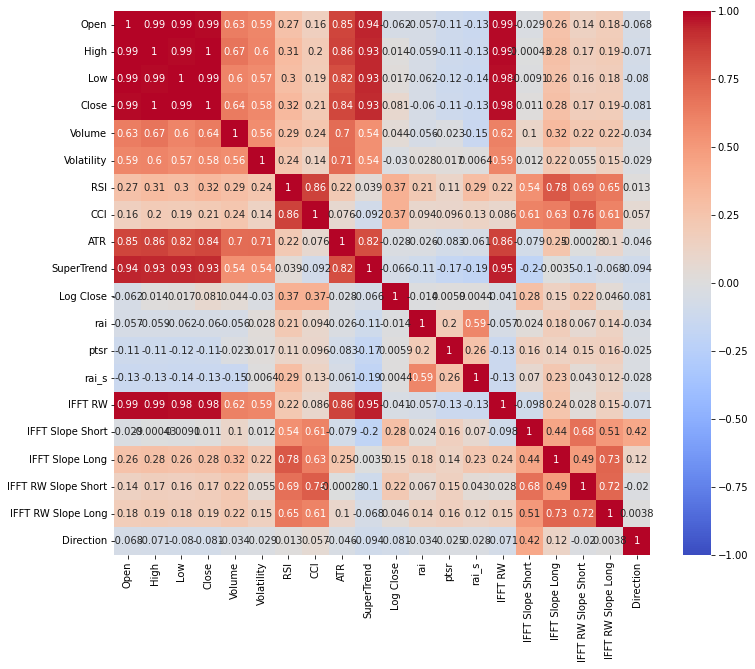

In [115]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Variance Inflation Factor

In [116]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add a constant to the features matrix (intercept term)
df_copy = df.copy()
df_copy['intercept'] = 1

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = df_copy.columns
vif_data['VIF'] = [variance_inflation_factor(df_copy.values, i) for i in range(df_copy.shape[1])]

print(vif_data)

                feature          VIF
0                  Open  1450.921417
1                  High   595.525823
2                   Low   242.744747
3                 Close  1450.370208
4                Volume     4.595440
5            Volatility     2.244220
6                   RSI     8.784290
7                   CCI     6.926072
8                   ATR     7.314387
9            SuperTrend    40.070674
10            Log Close    16.533410
11                  rai     1.568629
12                 ptsr     1.172970
13                rai_s     1.998145
14              IFFT RW  2144.960281
15     IFFT Slope Short     3.471355
16      IFFT Slope Long     6.671884
17  IFFT RW Slope Short    95.844935
18   IFFT RW Slope Long    37.459962
19            Direction     1.773978
20            intercept   273.442387


Correlation Matrix and Variance Inflation Factor suggest high multicolinearity.

## Modeling

In [117]:
len_df = int(len(df)/2)

df_train = df.iloc[:len_df]
df_test = df.iloc[len_df:]

df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [118]:
# Select y varaible
y_train = df_train['Direction']
y_test = df_test['Direction']

X_train = df_train
X_train.drop(['Direction'],axis = 1,inplace = True)

X_test = df_test
X_test.drop(['Direction'],axis = 1,inplace = True)

In [119]:
# Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Support Vector Machine

Manual Grid Search

In [185]:
# Set up the parameter grid to search for best gamma and C
param_grid = {
    'C': [1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']  # We are using the RBF kernel here
}

testing_accuracies = {}

# Manual grid search
for i in range(len(param_grid['C'])):
    for j in range(len(param_grid['gamma'])):
        
        # Train the model with a non-linear kernel
        model = SVC(kernel='rbf', C=param_grid['C'][i], gamma=param_grid['gamma'][j], random_state=42)
        model.fit(X_train_scaled, y_train)

        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
        
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        
        testing_accuracies.update({test_accuracy: [param_grid['C'][i], param_grid['gamma'][j]]})

highest_accuracy = max(testing_accuracies)
params = testing_accuracies.get(highest_accuracy)

print('Grid Search:\n')

for key, value in testing_accuracies.items():
    print('Accuracy:', round(key, 2), 'C =', value[0], 'gamma =', value[1])

print('\nBest Parameters: c =', params[0], 'gamma =', params[1], 'Accuracy:', round(highest_accuracy, 2))

# Fitting model with optomized parameters
model = SVC(kernel='rbf', C=params[0], gamma=params[1], random_state=42)
model.fit(X_train_scaled, y_train)

Grid Search:

Accuracy: 0.51 C = 1 gamma = 1
Accuracy: 0.65 C = 1 gamma = 0.1
Accuracy: 0.79 C = 1 gamma = 0.01
Accuracy: 0.51 C = 1000 gamma = 1
Accuracy: 0.6 C = 10 gamma = 0.1
Accuracy: 0.77 C = 10 gamma = 0.01
Accuracy: 0.76 C = 10 gamma = 0.001
Accuracy: 0.59 C = 1000 gamma = 0.1
Accuracy: 0.72 C = 100 gamma = 0.01
Accuracy: 0.8 C = 100 gamma = 0.001
Accuracy: 0.66 C = 1000 gamma = 0.01
Accuracy: 0.81 C = 1000 gamma = 0.001

Best Parameters: c = 1000 gamma = 0.001 Accuracy: 0.81


SVC(C=1000, gamma=0.001, random_state=42)

## Model Evaluation

Check for overfitting

In [186]:
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)
        
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print('Training Accuracy:', round(train_accuracy, 2))
print('Testing Accuracy:', round(test_accuracy, 2))

Training Accuracy: 0.93
Testing Accuracy: 0.81


Confusion Matrix

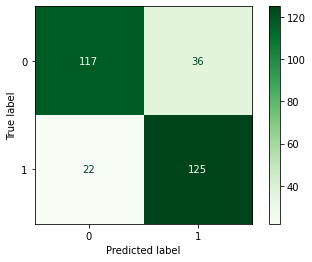

In [187]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test, labels=np.unique(df[['Direction']]))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')

# Show the plot
plt.show()

### Vizualizing Performance

Adding accuracy columns to dataframe

In [188]:
# Copying dataframe
df_copy = df.copy()
df_copy.drop(['Direction'],axis = 1,inplace = True)
X = df_copy.columns

# Creating dataframe for evaluation
eval_df = df.copy()

# transform columns
scaler = StandardScaler()
eval_df[X] = scaler.fit_transform(eval_df[X])

eval_df['Predicted Direction'] = model.predict(eval_df[X])

eval_df['Accuracy'] = 0
for i in range(len(df)):
    if eval_df['Direction'].iloc[i] != eval_df['Predicted Direction'].iloc[i]:
        eval_df['Accuracy'].iloc[i] = -1
    else:
        eval_df['Accuracy'].iloc[i] = 1
eval_df

,Open,High,Low,Close,Volume,Volatility,RSI,CCI,ATR,SuperTrend,...,ptsr,rai_s,IFFT RW,IFFT Slope Short,IFFT Slope Long,IFFT RW Slope Short,IFFT RW Slope Long,Direction,Predicted Direction,Accuracy
0,0.418292,0.332043,0.433834,0.411856,-0.030541,-0.176520,-0.716392,-0.884942,0.548900,0.869822,...,-0.054489,0.647624,0.479859,-0.578005,-0.808710,-0.682504,-0.455550,1,-1,-1
1,0.412028,0.453160,0.440826,0.535864,1.154353,-0.551125,-0.389984,-0.472351,0.544980,0.869822,...,-0.835279,-0.083210,0.457513,-0.712180,-0.723694,-0.408624,-0.612929,-1,-1,1
2,0.535350,0.431721,0.442113,0.429897,1.020090,-0.269706,-0.595924,-0.586908,0.509159,0.869822,...,-0.601817,-0.489197,0.442497,-0.802646,-0.651566,-0.279071,-0.679205,1,-1,-1
3,0.470327,0.527012,0.591377,0.607920,0.546206,-0.648226,-0.125975,0.108376,0.288733,0.869822,...,-0.128433,-0.726537,0.436885,-0.811425,-0.543647,0.148930,-0.544711,-1,-1,1
4,0.515213,0.546625,0.637072,0.616283,0.699416,-0.290682,-0.069464,0.181691,0.238869,0.869822,...,-0.032101,-0.976580,0.479492,-0.568550,-0.472129,0.398059,-0.132848,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,0.155214,0.081955,0.064114,0.010553,-0.322371,-0.050130,-0.066215,0.173214,0.142812,-0.066641,...,0.029473,-1.035766,0.281823,-0.919706,0.709488,-0.759834,0.445784,-1,-1,1
595,-0.018852,-0.099167,-0.137782,-0.125532,-0.287166,0.748569,-0.402792,-0.322369,0.086659,0.279397,...,-0.204240,-0.994814,0.147951,-1.197333,0.550621,-1.298124,-0.319934,1,-1,-1
596,-0.126428,-0.000275,-0.028860,0.078040,-0.589475,0.954102,0.152284,-0.038183,0.113314,0.279397,...,-0.204240,-0.861276,0.091043,-1.210764,0.449105,-1.019580,-0.583286,-1,-1,1
597,0.077450,0.076764,0.151874,0.082018,-0.060423,0.289081,0.162407,0.132486,0.009932,0.279397,...,0.480619,-0.716268,0.063087,-1.136926,0.338343,-0.507813,-0.747522,-1,-1,1


Vizualizing accuracy accross data

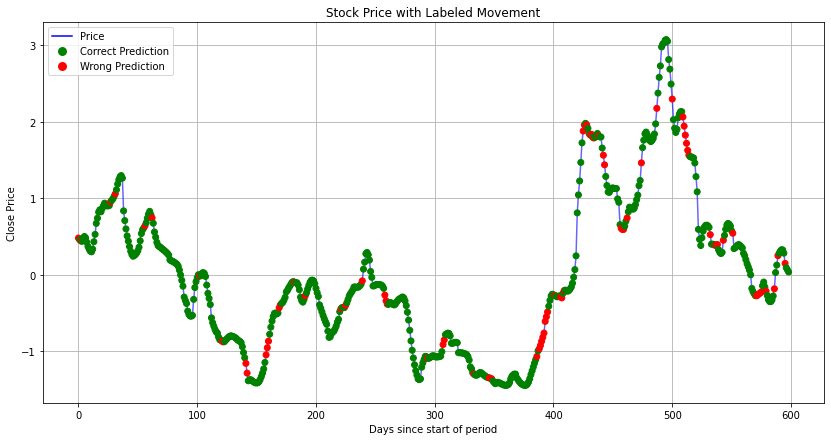

In [189]:
# Plot the stock prices
plt.figure(figsize=(14, 7))
plt.plot(eval_df['IFFT RW'], color='blue', alpha=0.6)

# Create a list with colors based on the values in the 'Direction' column
colors = ['red' if x == -1 else 'grey' if x == 0 else 'green' for x in eval_df['Accuracy']]

# Plot prices with color-coded results
plt.scatter(eval_df.index, eval_df['IFFT RW'], c=colors, label='Ticks', zorder=5)

# Customize the plot
plt.title('Stock Price with Labeled Movement')
plt.xlabel('Days since start of period')
plt.ylabel('Close Price')

# Add a legend to explain the color coding
legend_labels = {
    'blue': 'Price',
    'green': 'Correct Prediction',
    'red': 'Wrong Prediction',
}

# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], linestyle='-', color='blue', label=legend_labels['blue']),
    plt.Line2D([0], [0], marker='o', color='w', label=legend_labels['green'],
               markersize=10, markerfacecolor='green'),
    plt.Line2D([0], [0], marker='o', color='w', label=legend_labels['red'],
               markersize=10, markerfacecolor='red')]

# Add legend to plot
plt.legend(handles=legend_handles, loc='upper left')

plt.grid(True)
plt.show()

### Accuracy of IFFT Strategy + SVM Classifier

Both Accuracy Score: 0.79 (42/9)


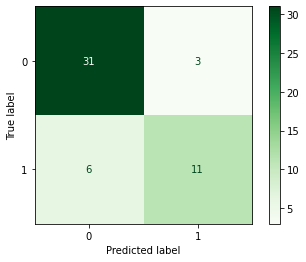

Model Accuracy Score: 0.85 (519/80)


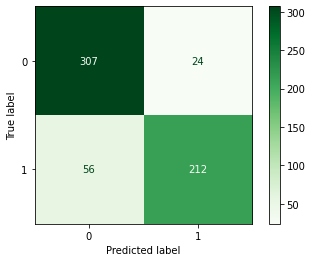

IFFT Accuracy Score: -0.53 (43/66)


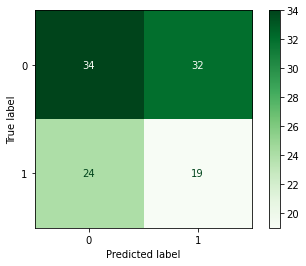

In [190]:
# IFFT + SVM

# Tracking accuracy
wrong = 0
right = 0

pred_vals = []
true_vals = []

for i in range(len(df)):
    if eval_df['IFFT RW Slope Short'].iloc[i] > 1 and eval_df['IFFT RW Slope Long'].iloc[i] > 0.5 and eval_df['Predicted Direction'].iloc[i] == 1:
        if eval_df['Accuracy'].iloc[i] == 1:
            right += 1
        else:
            wrong += 1
            
        pred_vals.append(eval_df['Predicted Direction'].iloc[i])
        true_vals.append(eval_df['Direction'].iloc[i])
    
    elif eval_df['IFFT RW Slope Short'].iloc[i] < -1 and eval_df['IFFT RW Slope Long'].iloc[i] < -0.5 and eval_df['Predicted Direction'].iloc[i] == -1:
        if eval_df['Accuracy'].iloc[i] == 1:
            right += 1
        else:
            wrong += 1
        
        pred_vals.append(eval_df['Predicted Direction'].iloc[i])
        true_vals.append(eval_df['Direction'].iloc[i])            
        
print('Both Accuracy Score:', round(1 - (wrong/right), 2), f'({right}/{wrong})')

# Generate the confusion matrix
cm = confusion_matrix(true_vals, pred_vals, labels=np.unique(df[['Direction']]))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')

# Show the plot
plt.show()

# SVM Only

# Tracking accuracy
wrong = 0
right = 0

pred_vals = []
true_vals = []

for i in range(len(df)):
    if eval_df['Predicted Direction'].iloc[i] == 1:
        if eval_df['Accuracy'].iloc[i] == 1:
            right += 1
        else:
            wrong += 1
            
        pred_vals.append(eval_df['Predicted Direction'].iloc[i])
        true_vals.append(eval_df['Direction'].iloc[i])
    
    elif eval_df['Predicted Direction'].iloc[i] == -1:
        if eval_df['Accuracy'].iloc[i] == 1:
            right += 1
        else:
            wrong += 1
        
        pred_vals.append(eval_df['Predicted Direction'].iloc[i])
        true_vals.append(eval_df['Direction'].iloc[i])            
        
print('Model Accuracy Score:', round(1 - (wrong/right), 2), f'({right}/{wrong})')

# Generate the confusion matrix
cm = confusion_matrix(true_vals, pred_vals, labels=np.unique(df[['Direction']]))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')

# Show the plot
plt.show()

# IFFT Only

# Tracking accuracy
wrong = 0
right = 0

pred_vals = []
true_vals = []

for i in range(len(df)):
    if eval_df['IFFT RW Slope Short'].iloc[i] > 1 and eval_df['IFFT RW Slope Long'].iloc[i] > 0.5:
        if eval_df['Direction'].iloc[i] == 1:
            right += 1
        else:
            wrong += 1
            
        pred_vals.append(1)
        true_vals.append(eval_df['Direction'].iloc[i])
    
    elif eval_df['IFFT RW Slope Short'].iloc[i] < -1 and eval_df['IFFT RW Slope Long'].iloc[i] < -0.5:
        if eval_df['Direction'].iloc[i] == 1:
            right += 1
        else:
            wrong += 1
        
        pred_vals.append(-1)
        true_vals.append(eval_df['Direction'].iloc[i])            
        
print('IFFT Accuracy Score:', round(1 - (wrong/right), 2), f'({right}/{wrong})')

# Generate the confusion matrix
cm = confusion_matrix(true_vals, pred_vals, labels=np.unique(df[['Direction']]))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')

# Show the plot
plt.show()

Using PCA to data so it can be graphed in 2-3 dimensions.

## Vizualizing SVM Hyperplanes

In [160]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df)

pca_values = pd.DataFrame({'expl_var': pca.explained_variance_ratio_, 
                      'component': range(1,21), 
                      'cum_variance': pca.explained_variance_ratio_.cumsum()})

pca_values.head()

,expl_var,component,cum_variance
0,1.000000e+00,1,1.0
1,1.388931e-13,2,1.0
2,4.696979e-16,3,1.0
3,1.611212e-17,4,1.0
4,1.009961e-17,5,1.0


In [161]:
df_pca = pca.transform(df)
df_pca = pd.DataFrame(df_pca[:, 1:4])

df_pca['Predicted Direction'] = y_train
df_pca.head()

,0,1,2,Predicted Direction
0,-104.855149,-0.339267,0.248803,1.0
1,-89.368507,1.332698,1.786241,-1.0
2,-99.363849,2.627849,1.201700,1.0
3,-2.895212,3.539891,1.329939,-1.0
4,1.490609,3.768468,0.907091,-1.0


3D Scatter Plot

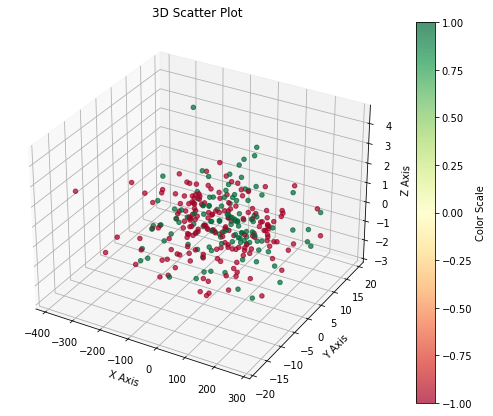

In [162]:
# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_pca[0], df_pca[1], df_pca[2], c=df_pca['Predicted Direction'], cmap='RdYlGn', alpha=0.7)

# Add color bar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Color Scale')

# Labels and title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Scatter Plot')

# Show plot
plt.show()

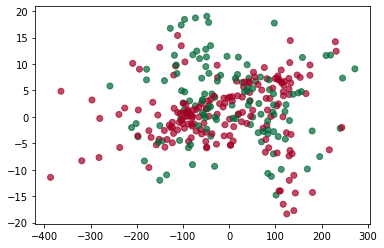

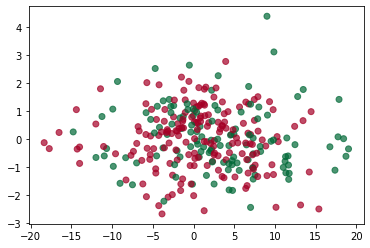

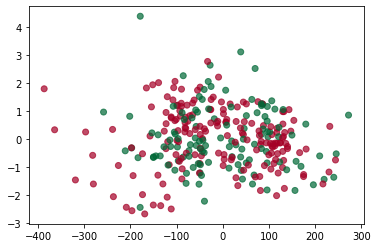

In [163]:
plt.scatter(df_pca[0],df_pca[1], c=df_pca['Predicted Direction'], cmap='RdYlGn', alpha=0.7)
plt.show()
plt.scatter(df_pca[1],df_pca[2], c=df_pca['Predicted Direction'], cmap='RdYlGn', alpha=0.7)
plt.show()
plt.scatter(df_pca[0],df_pca[2], c=df_pca['Predicted Direction'], cmap='RdYlGn', alpha=0.7)
plt.show()